# Inverse Problems Exercises: 2024s s06 (non-physics)
https://www.umm.uni-heidelberg.de/miism/

## Notes
* Please **DO NOT** change the name of the `.ipynb` file. 
* Please **DO NOT** import extra packages to solve the tasks. 
* Please put the `.ipynb` file directly into the `.zip` archive without any intermediate folder. 

## Please provide your personal information
* full name (Name): 

Quang Minh, Ngo

## D05b: Pseudo-inverse

In [100]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import solve_sylvester

In [101]:
file_gaussian = 'file_gaussian.npz'
with np.load(file_gaussian) as data:
    f_true = data['f_true']
    A_psf = data['A_psf']
    list_gn = data['list_gn']

### Imaging model
The imaging model can be represented by
$$
g = h \otimes f_\text{true}
= Af_\text{true}
= \mathcal{F}^{-1}\{ \mathcal{F}\{h\} \mathcal{F}\{f_\text{true}\} \},
$$
$$
g' = g + \epsilon.
$$
* $f_\text{true}$ is the input signal
* $h$ is the point spread function (kernel)
* $\otimes$ is the convolution operator
* $A$ is the Toeplitz matrix of $h$
* $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the Fourier transform operator and inverse Fourier transform operator
* $\epsilon$ is the additive Gaussian noise
* $g$ is the filtered signal
* $g'$ is the noisy signal

### Downsampling
* Implement the downsampling matrix
$$D_\text{ds} = \begin{bmatrix} 
1 & 0 & 0 & 0 & 0 & ... \\
0 & 0 & 1 & 0 & 0 & ... \\
0 & 0 & 0 & 0 & 1 & ... \\
  &   &   & ... & &     \end{bmatrix}_{n/2 \times n}$$
* Given the size $n_\text{ds}$
* Implement the function `get_downsampling_matrix()` (using `numpy.array`)

Prepare the data with downsampling
* Downsample the signal in `list_gn[0]` and save the output in the variable `gn_ds` (as `numpy.array`)
* Calculate the system matrix with downsampling with `A_psf` and save the output in the variable `A_ds` (as `numpy.array`)

In [102]:
def get_downsampling_matrix(n):
    """ Create downsampling matrix.

    :param n: Size of the input signal
    :returns: 2d matrix of size (n/2, n)
    """
    matr = np.zeros((n//2, n))
    matr[np.arange(n//2), np.arange(0, n, 2)] = 1
    return matr

n = len(list_gn[0])
D_s = get_downsampling_matrix(n)
gn_ds = np.dot(D_s, list_gn[0])
A_ds = np.dot(D_s, A_psf)

In [103]:
# This cell contains hidden tests.


### Pseudo-inverse solutions
In the structure of Tikhonov regularization, a general solution can be written with a pseudo-inverse $A^{-I}$:
$$
\tilde f = A^{-I} g.
$$
$A^{-I}$ is a matrix satisfying the following expression:
$$
\alpha_1 (A^T A) A^{-I} + A^{-I} (\alpha_2 A A^T + \alpha_3 \operatorname{cov}(g)) = (\alpha_1 + \alpha_2) A^T,
$$
where $\alpha_1$, $\alpha_2$, $\alpha_3$ are the specific parameters. Especially,
* when $\alpha_1 = 1$, $\alpha_2 = 0$, $\alpha_3 = \lambda$, $\operatorname{cov}(g) = I$, it is the damped least squares
$$
A^{-I} = (A^T A + \lambda I) ^{-1} A^T ,
$$
* when $\alpha_1 = 0$, $\alpha_2 = 1$, $\alpha_3 = \lambda$, $\operatorname{cov}(g) = I$, it is the damped minimum length
$$
A^{-I} = A^T (A^T A + \lambda I) ^{-1} .
$$

Implement the pseudo-inverse calculation
* Given the system matrix $A$
* Given the covariance $\operatorname{cov}(g)$
* Given the parameter set $(\alpha_1, \alpha_2, \alpha_3)$
* Solving the Sylvester equation (using ```scipy.linalg.solve_sylvester()```)
* Implement the function `solve_pseudo_inverse()` (using `numpy.array`)

Calculation the pseudo-inverse solutions
* Calculate the solutions for the downsampled data `gn_ds` and `A_ds`
* Use $\operatorname{cov}(g) = I$
* Use 9 different parameter sets $(\alpha_1, \alpha_2, \alpha_3)$ as follows:
$$
\begin{array}{lll}
 (1, 0, 0),    &(0.5, 0.5, 0),    &(0, 1, 0), \\
 (1, 0, 0.01), &(0.5, 0.5, 0.01), &(0, 1, 0.01), \\
 (1, 0, 0.1),  &(0.5, 0.5, 0.1),  &(0, 1, 0.1) \\
\end{array}
$$
* Save the pseudo-inverse matrices in the variable `list_A_inv` (as `list` of `numpy.array`)
* Save the pseudo-inverse solutions in the variable `list_f_inv` (as `list` of `numpy.array`)

Display the result
* Plot the outputs in `list_f_inv` in the same order of the parameter options in the subplots of `axs`
* Plot the noisy signal `gn_ds` at the corresponding space coordinates in each subplot
* Plot the input signal `f_true` in each subplot
* Show the legend in each subplot
* Show the case information in the titles to the subplots

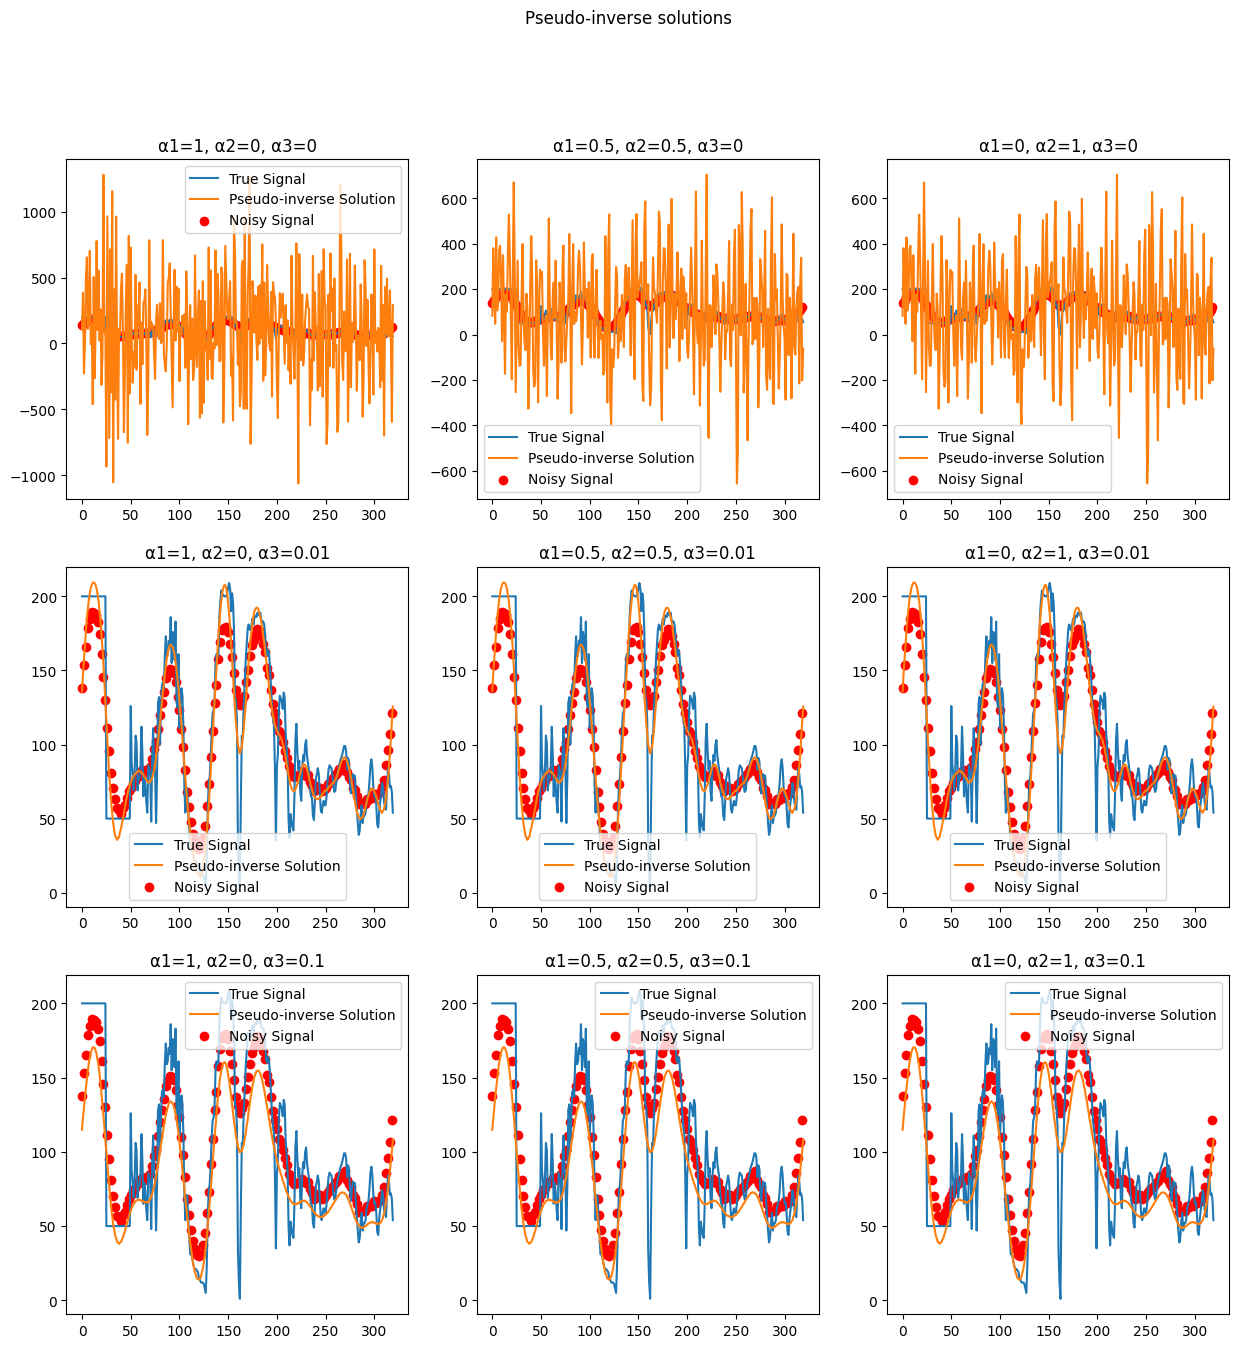

In [104]:
def solve_pseudo_inverse(A, cov_g, alpha):
    """ 
    :param A: System matrix.
    :param cov_g: Covariance of g.
    :param alpha: Array of 3 alpha values.
    :returns: Pseudo-inverse matrix.
    """
    a = alpha[0] * np.dot(A.T, A)
    b = alpha[1] * np.dot(A, A.T) + alpha[2] * cov_g
    q = (alpha[0] + alpha[1]) * A.T
    return solve_sylvester(a, b, q)

cov_g = np.eye(len(gn_ds))
params = [
    (1, 0, 0), (0.5, 0.5, 0), (0, 1, 0),
    (1, 0, 0.01), (0.5, 0.5, 0.01), (0, 1, 0.01),
    (1, 0, 0.1), (0.5, 0.5, 0.1), (0, 1, 0.1)
    ]
list_A_inv = []
list_f_inv = []
for param in params:
    A_inv = solve_pseudo_inverse(A_ds, cov_g, param)
    f_inv = np.dot(A_inv, gn_ds)
    list_A_inv.append(np.array(A_inv))
    list_f_inv.append(np.array(f_inv))
    
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Pseudo-inverse solutions')

for i, (f_inv, param) in enumerate(zip(list_f_inv, params)):
    row = i // 3
    col = i % 3
    axs[row, col].plot(f_true, label='True Signal')
    axs[row, col].plot(f_inv, label='Pseudo-inverse Solution')
    axs[row, col].scatter(np.arange(len(gn_ds)) * 2, gn_ds, color='red', label='Noisy Signal')
    axs[row, col].legend()
    axs[row, col].set_title(f'α1={param[0]}, α2={param[1]}, α3={param[2]}')

plt.show()

In [105]:
# This cell contains hidden tests.


In [106]:
# This cell contains hidden tests.


### Question: Bias
In which result do you observe the bias of the solution?
  - Bias means that the amplitude of the signal is changed in the solution.

YOUR ANSWER HERE

For cases 0, 1, and 2 with $α_3 = 0$, especially case 0, the MSE of them are the highest, indicating the most significant bias of the solution. This also means the the amplitude of the signal is changed the most to the true signal.

In [107]:
list_mse = [np.mean((f_true-f_inv)**2) for f_inv in list_f_inv]
print('MSE for each case:')
for i, param in enumerate(params):
    print(f'Case {i}: α1={param[0]:<4} α2={param[1]:<4} α3={param[2]:<5}: {list_mse[i]}')

MSE for each case:
Case 0: α1=1    α2=0    α3=0    : 164292.4783047866
Case 1: α1=0.5  α2=0.5  α3=0    : 50780.258649579766
Case 2: α1=0    α2=1    α3=0    : 50780.25864955402
Case 3: α1=1    α2=0    α3=0.01 : 419.6631483958028
Case 4: α1=0.5  α2=0.5  α3=0.01 : 419.66314839579763
Case 5: α1=0    α2=1    α3=0.01 : 419.6631483957984
Case 6: α1=1    α2=0    α3=0.1  : 977.4665563086999
Case 7: α1=0.5  α2=0.5  α3=0.1  : 977.4665563086946
Case 8: α1=0    α2=1    α3=0.1  : 977.4665563087085


### Resolution matrices and covariance matrix
The related matrices, i.e. the data resolution matrix $N$, the model resolution matrix $R$ and the covariance matrix $\operatorname{cov}(f)$, are defined as follows:
$$
\begin{align*}
N &= A A^{-I} \\
R &= A^{-I} A \\
\operatorname{cov}(f) &= A^{-I} \operatorname{cov}(g) (A^{-I})^T \\
\end{align*}
$$
* Given $A$, $A^{-I}$, $\operatorname{cov}(g)$
* Implement the function `get_data_resolution_matrix()` (using `numpy.array`)
* Implement the function `get_model_resolution_matrix()` (using `numpy.array`)
* Implement the function `get_cov_f()` (using `numpy.array`)

Calculate the matrices
* Calculate the matrices for the pseudo-inverse matrices in `list_A_inv`
* Save the data resolution matrices $N$ in the variable `list_N` (as `list` of `numpy.array`)
* Save the model resolution matrices $R$ in the variable `list_R` (as `list` of `numpy.array`)
* Save the covariance matrices $\operatorname{cov}(f)$ in the variable `list_cov_f` (as `list` of `numpy.array`)

Display the result
* Plot the matrices in `list_N` as images in the same order of the parameter options in the subplots of `axs_N`
* Plot the matrices in `list_R` as images in the same order of the parameter options in the subplots of `axs_R`
* Plot the matrices in `list_cov_f` as images in the same order of the parameter options in the subplots of `axs_cov_F`
* Show the colorbar of each subplot
* Show the case information in the titles to the subplots

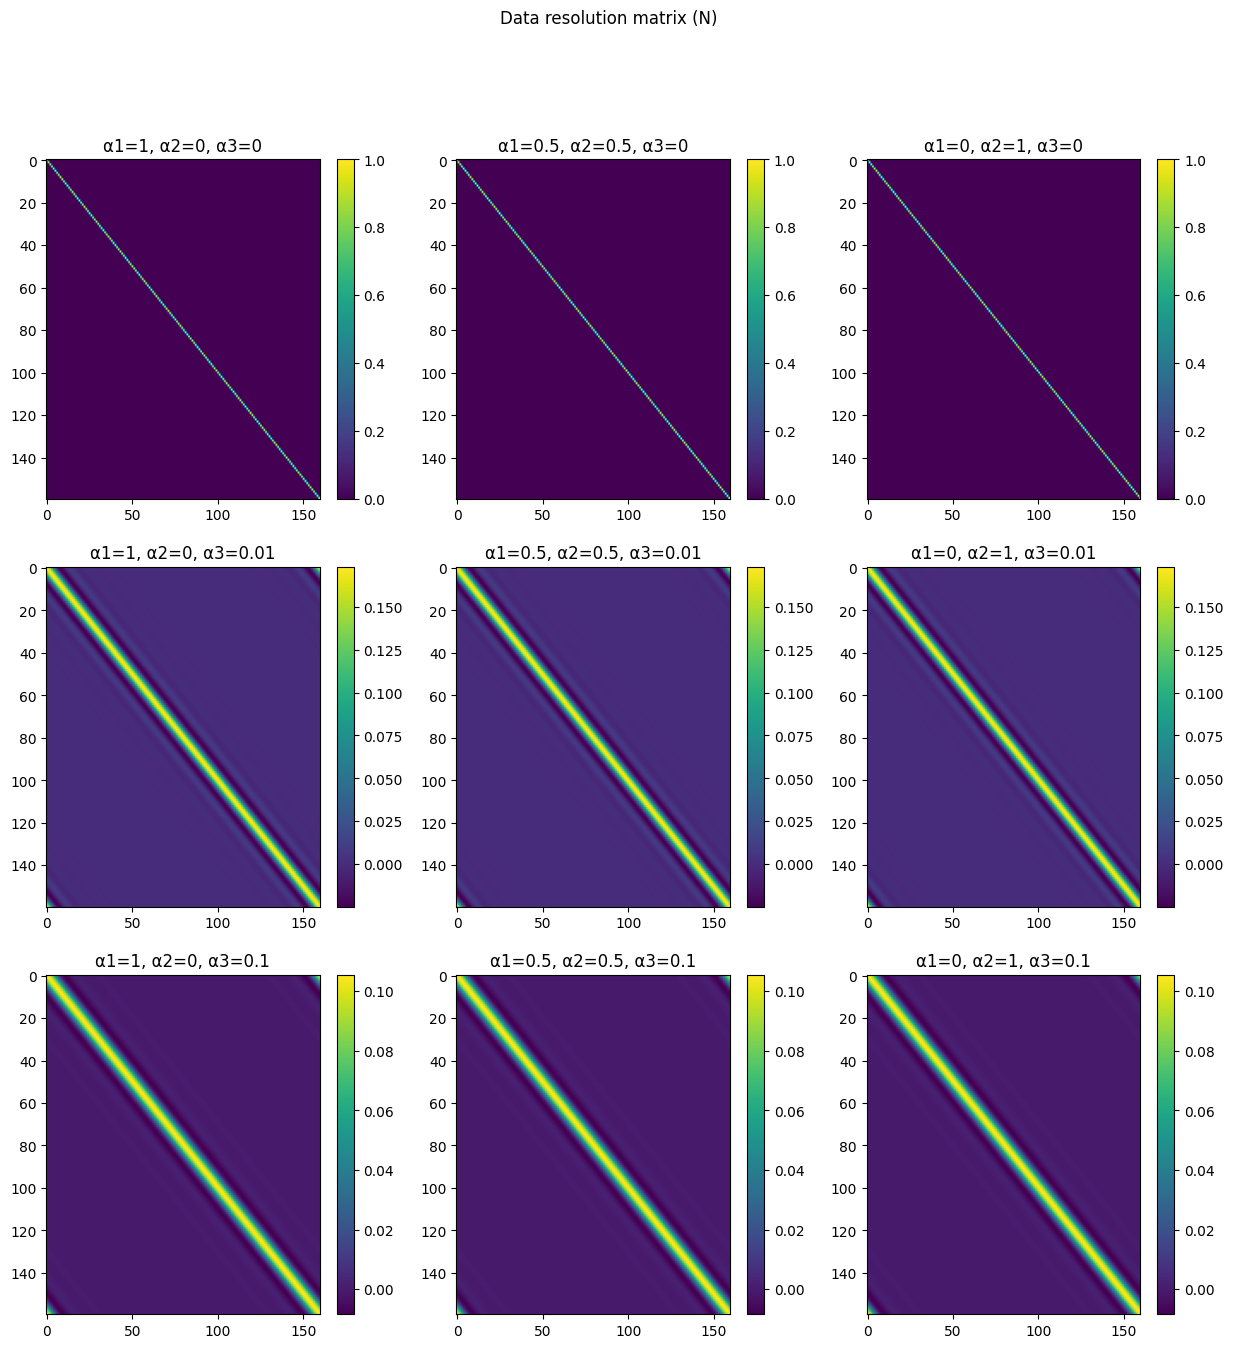

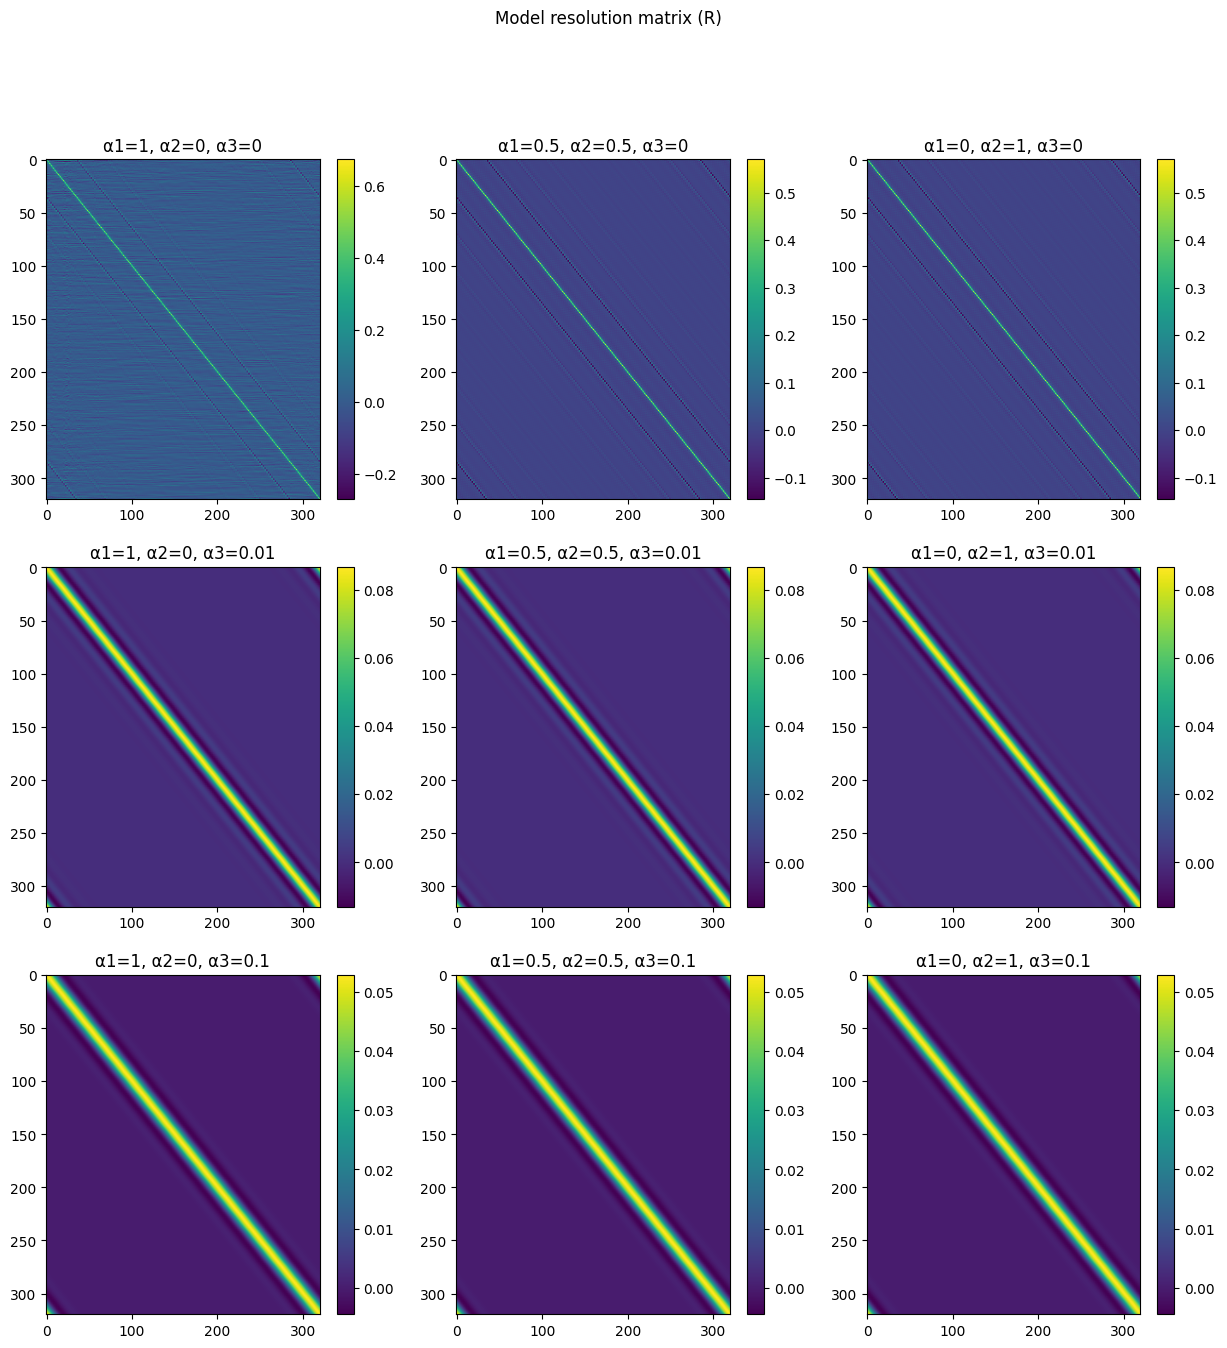

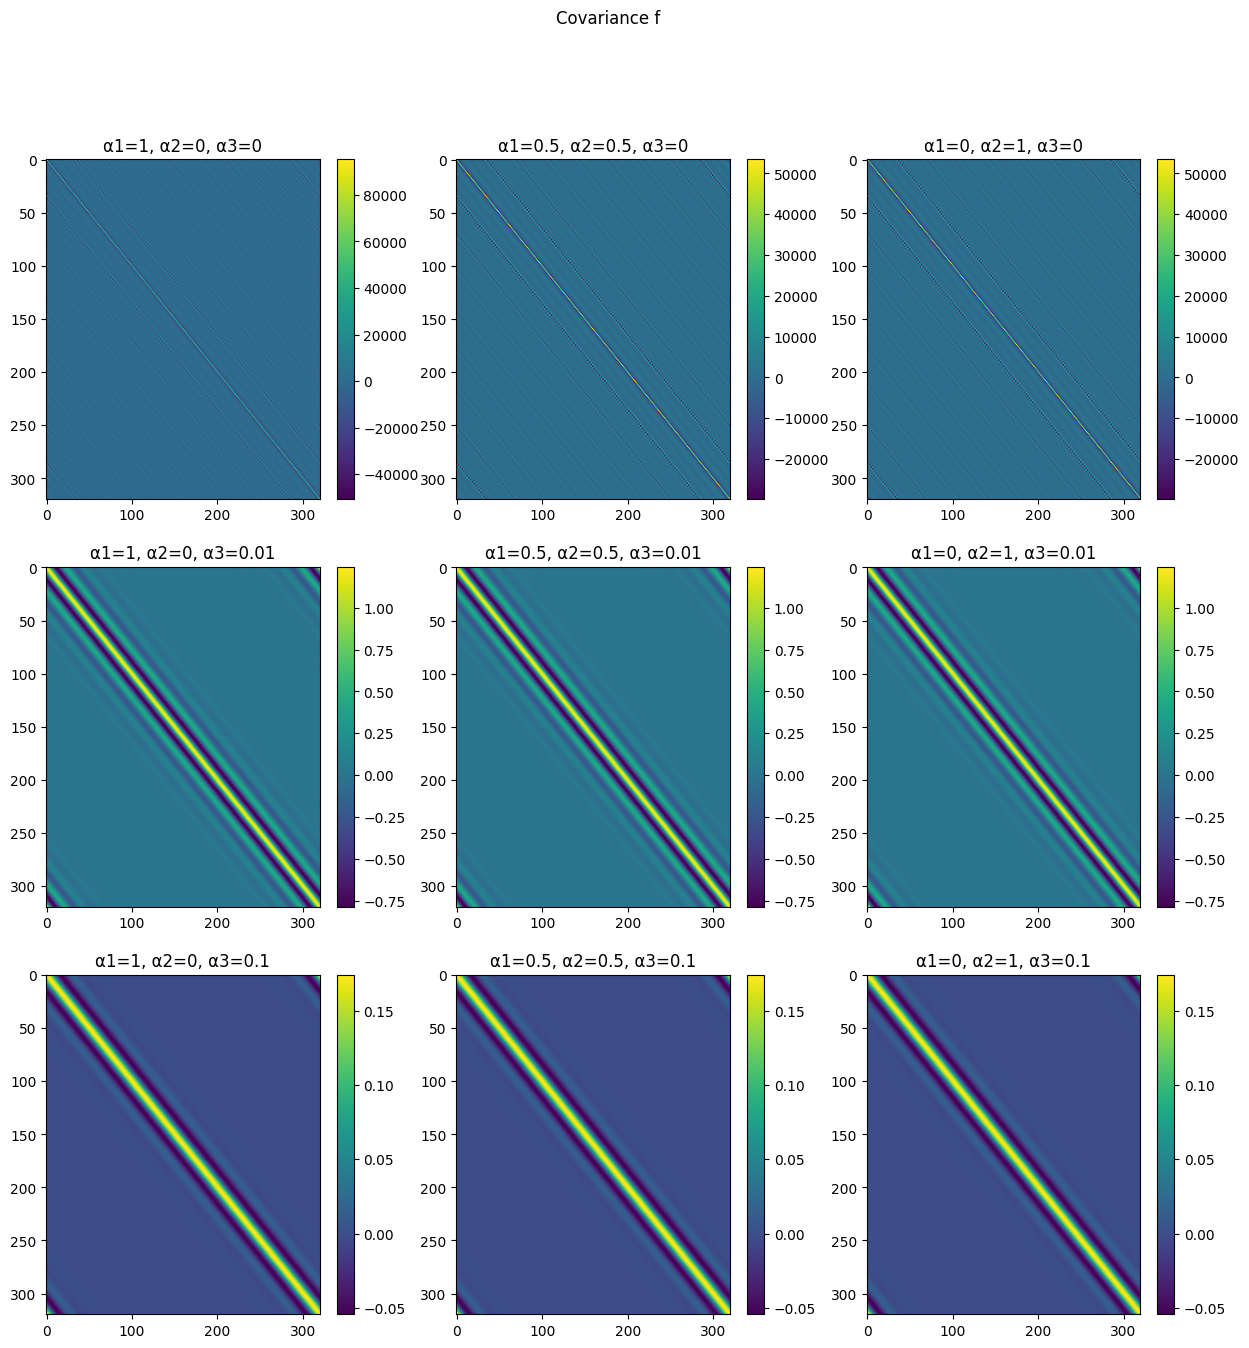

In [108]:
def get_data_resolution_matrix(A, A_I):
    """
    :param A: System matrix.
    :param A_I: Pseudo-inverse matrix.
    :returns: Data resolutin matrix.
    """
    return np.dot(A, A_I)

def get_model_resolution_matrix(A, A_I):
    """
    :param A: System matrix.
    :param A_I: Pseudo-inverse matrix.
    :returns: Model resolutin matrix.
    """
    return np.dot(A_I, A)

def get_cov_f(cov_g, A_I):
    """
    :param cov_g: Covariance of g.
    :param A_I: Pseudo-inverse matrix.
    :returns: Covariance of f.
    """
    return np.dot(A_I, np.dot(cov_g, A_I.T))

list_N = [get_data_resolution_matrix(A_ds, A_inv) for A_inv in list_A_inv]
list_R = [get_model_resolution_matrix(A_ds, A_inv) for A_inv in list_A_inv]
list_cov_f = [get_cov_f(cov_g, A_inv) for A_inv in list_A_inv]

fig, axs_N = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Data resolution matrix (N)')

    
fig, axs_R = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Model resolution matrix (R)')
fig.patch.set_alpha(0.3)

    
fig, axs_cov_f = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Covariance f')

for i, (N, R, cov_f, param) in enumerate(zip(list_N, list_R, list_cov_f, params)):
    row = i // 3
    col = i % 3
    
    im_N = axs_N[row, col].imshow(N, aspect='auto')
    axs_N[row, col].set_title(f'α1={param[0]}, α2={param[1]}, α3={param[2]}')
    fig.colorbar(im_N, ax=axs_N[row, col])
    
    im_R = axs_R[row, col].imshow(R, aspect='auto')
    axs_R[row, col].set_title(f'α1={param[0]}, α2={param[1]}, α3={param[2]}')
    fig.colorbar(im_R, ax=axs_R[row, col])
    
    im_cov_f = axs_cov_f[row, col].imshow(cov_f, aspect='auto')
    axs_cov_f[row, col].set_title(f'α1={param[0]}, α2={param[1]}, α3={param[2]}')
    fig.colorbar(im_cov_f, ax=axs_cov_f[row, col])

plt.show()
    
# * some points
#   - Check whether the colorbar is shown
#   - Check whether the titles are correct

In [109]:
# This cell contains hidden tests.


In [110]:
# This cell contains hidden tests.


### Characteristics
The characteristics, i.e. the spread of a matrix $\operatorname{spread}()$ and the signal size $\operatorname{size}()$, are defined as follows:
$$
\begin{align*}
\operatorname{spread}(B) &= \| B - I \|_2^2 = \sum_{ij}(B_{ij} - \delta_{ij})^2 \\
\operatorname{size}(f) &= \sum_i \operatorname{cov}(f)_{ii} \\
\end{align*}
$$
* Implement the function `get_spread()` (using `numpy.array`)
* Implement the function `get_size()` (using `numpy.array`)

Calculate the characteristics
* Calculate the characteristics for the matrices in `list_N`, `list_R`, `list_cov_f`
* Save the spread $\operatorname{spread}(N)$ in the variable `list_spread_N` (as `list`)
* Save the spread $\operatorname{spread}(R)$ in the variable `list_spread_R` (as `list`)
* Save the size $\operatorname{size}(f)$ in the variable `list_size_f` (as `list`)
* Save the case index corresponding to the minimal $\operatorname{spread}(N)$ in the variable `idx_spread_N` (as `scalar`)
* Save the case index corresponding to the minimal $\operatorname{spread}(R)$ in the variable `idx_spread_R` (as `scalar`)
* Save the case index corresponding to the minimal $\operatorname{size}(f)$ in the variable `idx_size_f` (as `scalar`)

Display the result
* Plot the value pairs in `list_spread_N` and `list_spread_R` as 2D scatter points in different colors in the left subplot of `axs`
* Plot the value pairs in `list_spread_R` and `list_size_f` as 2D scatter points in different colors in the middle subplot of `axs`
* Plot the value pairs in `list_size_f` and `list_spread_N` as 2D scatter points in different colors in the right subplot of `axs`
* Show the legend in each subplot
* Show the case information and point values in the legend
* Highlight the cases corresponding to the minimal values in the legend

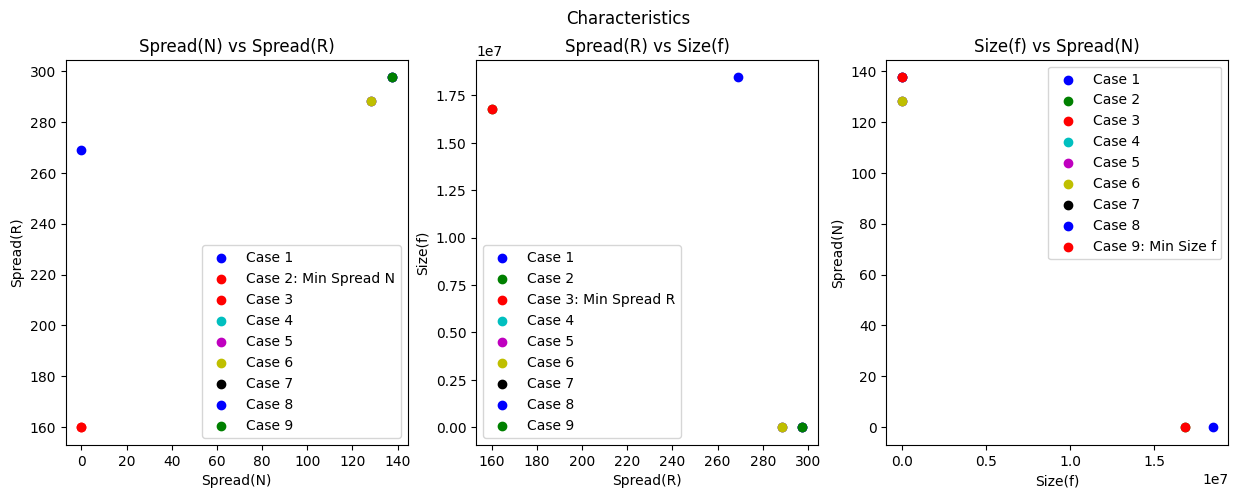

In [111]:
def get_spread(B):
    """ 
    :param B: Input matrix.
    :returns: Spread of the input matrix.
    """
    I = np.eye(B.shape[0])
    return np.linalg.norm(B - I)**2

def get_size(cov_f):
    """ 
    :param cov_f: Covariance of f.
    :returns: Size of f.
    """
    return np.trace(cov_f)

list_spread_N = [get_spread(N) for N in list_N]
list_spread_R = [get_spread(R) for R in list_R]
list_size_f = [get_size(cov_f) for cov_f in list_cov_f]

idx_spread_N = np.argmin(list_spread_N)
idx_spread_R = np.argmin(list_spread_R)
idx_size_f = np.argmin(list_size_f)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Characteristics')

# Colors for each case
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plotting list_spread_N vs list_spread_R

# Scatter each case with a different color and legend entry
for idx, (n, r) in enumerate(zip(list_spread_N, list_spread_R)):
    if idx == idx_spread_N:
        color = 'r'
        label = f'Case {idx+1}: Min Spread N'
        s = 100
    else:
        color = colors[idx % len(colors)]
        label = f'Case {idx+1}'
        s = 10
    axs[0].scatter(n, r, c=color, label=label)

axs[0].set_xlabel('Spread(N)')
axs[0].set_ylabel('Spread(R)')
axs[0].legend()
axs[0].set_title('Spread(N) vs Spread(R)')


# Plotting list_spread_R vs list_size_f
# Scatter each case with a different color and legend entry
for idx, (r, f) in enumerate(zip(list_spread_R, list_size_f)):
    if idx == idx_spread_R:
        color = 'r'
        label = f'Case {idx+1}: Min Spread R'
        s = 100
    else:
        color = colors[idx % len(colors)]
        label = f'Case {idx+1}'
        s = 10
    axs[1].scatter(r, f, c=color, label=label)
axs[1].set_xlabel('Spread(R)')
axs[1].set_ylabel('Size(f)')
axs[1].legend()
axs[1].set_title('Spread(R) vs Size(f)')

# Plotting list_size_f vs list_spread_N
for idx, (f, n) in enumerate(zip(list_size_f, list_spread_N)):
    if idx == idx_size_f:
        color = 'r'
        label = f'Case {idx+1}: Min Size f'
        s = 100
    else:
        color = colors[idx % len(colors)]
        label = f'Case {idx+1}'
        s = 10
    axs[2].scatter(f, n, c=color, label=label)
axs[2].set_xlabel('Size(f)')
axs[2].set_ylabel('Spread(N)')
axs[2].legend()
axs[2].set_title('Size(f) vs Spread(N)')
plt.show()


In [112]:
# This cell contains hidden tests.


### Question: Selection
Which pseudo inverse do you prefer to minimize $\operatorname{spread}(N) + \operatorname{spread}(R)+ \operatorname{size}(f)$?

YOUR ANSWER HERE

As executing an operation to calculate each sum for triple ($\operatorname{spread}(N), \operatorname{spread}(R), \operatorname{size}(f)$), I find that case index 8 where $α_1 = 0, α_2 = 1$, and $α_3 = 0.1$ gives the minimum result for above sum.

In [113]:
sum_list = [N + R + cov_f for N, R, cov_f in zip(list_spread_N, list_spread_R, list_size_f)]
idx_sum = np.argmin(sum_list)
print(f'Index of minimum sum: {idx_sum}')
print(f'Parameters for minimize Spread(N) + Spread(R) + Size(f): α1={params[idx_sum][0]}, α2={params[idx_sum][1]}, α3={params[idx_sum][2]}')

Index of minimum sum: 8
Parameters for minimize Spread(N) + Spread(R) + Size(f): α1=0, α2=1, α3=0.1
